In [5]:
%matplotlib inline
from deep_rl_ga.ga_env import GeneticAlgorithmEnv
from deep_rl_ga.agent import Agent
from deep_rl_ga.memory import Experience, ReplayMemory, extract_tensors
from deep_rl_ga.strategy import EpsilonGreedyStrategy
from deep_rl_ga.network import DQN
from deep_rl_ga.qvalues import QValues

from deap import benchmarks
from deap import tools

import torch
import torch.optim as optim
import torch.nn.functional as F

from itertools import count
import random

import numpy as np

import matplotlib.pyplot as plt
from IPython import display


def plot(values, moving_avg_period, is_ipython=True):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Best fitness')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print('Episode', len(values), '\n', moving_avg_period, 'episode moving avg:', moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


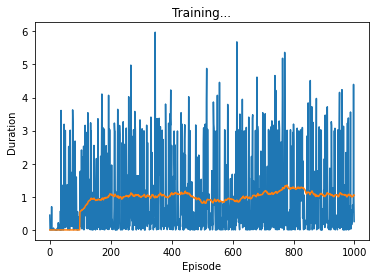

Episode 1000 
 100 episode moving avg: 1.0509282


In [6]:
# Genetic algorithm params
IND_SIZE = 3
LOW_BOUND = -5.12
UP_BOUND = 5.12
FITNESS_FUNCTION = benchmarks.rastrigin

# Crossover + Mutation params
MATING_RATE = 0.3
INDIVIDUAL_MUTATION_RATE = 0.3

# Selection params
TOURNAMENT_SIZE = 3
TOP_BEST_SIZE = 10

INITIAL_POPULATION_SIZE = 150
MAX_EVALS = 10_000

RANDOM_SEED = 0

random.seed(
    RANDOM_SEED
    )
np.random.seed(
    RANDOM_SEED
    )

ACTIONS_SEL = [
    {'function': tools.selTournament, 'tournsize': TOURNAMENT_SIZE},
    {'function': tools.selBest, 'k': TOP_BEST_SIZE},
]

ACTIONS_CX = [
    {'function': tools.cxBlend, 'alpha': UP_BOUND},
    {'function': tools.cxTwoPoint},
]

ACTIONS_MU = [
    {'function': tools.mutGaussian, 'mu': 0, 'sigma': 1, 'indpb': INDIVIDUAL_MUTATION_RATE},
    {'function': tools.mutShuffleIndexes, 'indpb': INDIVIDUAL_MUTATION_RATE},
]


# Neural network params
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100_000
lr = 0.001
num_episodes = 1000

curr_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = GeneticAlgorithmEnv(
    num_dims=IND_SIZE,
    low_bound=LOW_BOUND,
    up_bound=UP_BOUND,
    fitness_fn=benchmarks.rastrigin,
    max_evals=MAX_EVALS,
    initial_population_size=INITIAL_POPULATION_SIZE,
    actions_sel=ACTIONS_SEL,
    actions_cx=ACTIONS_CX,
    actions_mu=ACTIONS_MU,
    device=curr_device,
)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), curr_device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_num_state_features(), em.num_actions_available()).to(curr_device)
target_net = DQN(em.get_num_state_features(), em.num_actions_available()).to(curr_device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_best_fitnesses = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()

    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))

        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences, curr_device)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, curr_device)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
            episode_best_fitnesses.append(em.hof[0].fitness.values[0])
            plot(episode_best_fitnesses, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
    # if get_moving_average(100, episode_best_fitnesses)[-1] <= 0.0001:
    #     break
